## Imports and Configuration

In [2]:
import os
import wandb

import torch

import pytorch_lightning as pl

from config.load_configuration import load_configuration
from data.datamodule import ECG_DataModule
from model.model import UNET_1D

#### Loading configuration

This notebook loads configuration settings using the `load_configuration` function from the `config.load_configuration` module. The configuration is stored in the `config` variable.

In [3]:
config = load_configuration()

PC Name: DESKTOP-LUKAS
Loaded configuration from config/config_lukas.yaml


#### Logging in to Weights & Biases (wandb)

Before starting any experiment tracking, ensure you are logged in to your Weights & Biases (wandb) account. This enables automatic logging of metrics, model checkpoints, and experiment configurations. The following code logs you in to wandb:

```python
wandb.login()
```
If you are running this for the first time, you may be prompted to enter your API key.

In [4]:
wandb.login()

wandb: Currently logged in as: lukas-pelz (HKA-EKG-Signalverarbeitung) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [5]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

Seed set to 42


#### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*40)
print(f"Torch Version      : {torch.__version__}")
print(f"Selected Device    : {device}")
if device.type == 'cuda':
    print(f"CUDA Version       : {torch.version.cuda}")
    print(f"Device Name        : {torch.cuda.get_device_name(0)}")
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"Memory Usage       : Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB")
    torch.set_float32_matmul_precision('high')
else:
    print("CUDA not available, using CPU.")
print("="*40)

Torch Version      : 2.7.0+cu128
Selected Device    : cuda
CUDA Version       : 12.8
Device Name        : NVIDIA GeForce RTX 5060 Ti
Memory Usage       : Allocated: 0.00 GB | Reserved: 0.00 GB


#### Initializing the Data Module

The `ECG_DataModule` is instantiated with the data directory, batch size, and feature list from the configuration. The `setup(stage="test")` method prepares the data module for the test stage, ensuring the test data is ready for evaluation.

In [7]:
dm = ECG_DataModule(data_dir=config['path_to_data'], batch_size=config['batch_size'], feature_list=config['feature_list'])
dm.setup(stage="test")

In [9]:
checkpoint_path = config['path_to_models'] + "/1-lead_UNET_1D_2025-06-02_14-34.ckpt"
model = UNET_1D.load_from_checkpoint(checkpoint_path)
model.eval()

UNET_1D(
  (loss): BCELoss()
  (AvgPool1D1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (AvgPool1D2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (AvgPool1D3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (AvgPool1D4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (layer1): Sequential(
    (0): conbr_block(
      (net): Sequential(
        (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=same)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): conbr_block(
      (net): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): conbr_block(
      (net): Sequential(
        (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=same)
        (1): ReLU()
 

In [15]:
# Function to generate a plot of the ECG data and the labels
import matplotlib.pyplot as plt
import math
def generatePlot(x, y, x_hat, y_hat):
    fig, axs = plt.subplots(7, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 1, 1, 1, 1]})

    # Plot ECG data
    axs[0].plot(x[0].numpy(), color='blue')
    axs[0].set_title('ECG Data')
    # Range between min and max value of ECG data
    axs[0].set_ylim([min(x[0].numpy())*1.1, max(x[0].numpy())*1.1])
    axs[0].set_ylabel('Amplitude [normalized]')
    axs[0].set_yticks(range(math.floor(min(x[0].numpy())*1.1),math.floor(max(x[0].numpy())*1.1), 1))
    axs[0].set_xticks(range(0, 551, 50))

    # Plot labels
    for i in range(6):
        axs[i + 1].plot(y[i].numpy(), color='green')
        axs[i + 1].plot(y_hat[i].numpy(), color='blue')
        axs[i + 1].plot(abs(y[i].numpy() - y_hat[i].numpy()), color='red', linestyle='--')
        axs[i + 1].set_ylim([-0.1, 1.1])
        axs[i + 1].set_ylabel(config['feature_list'][i])
        axs[i + 1].set_yticks([0, 1])
        axs[i + 1].set_yticklabels(['0', '1'])
        axs[i + 1].set_xticks([])
        axs[i + 1].legend(['Ground truth', 'Prediction', '|Difference|'], fontsize='x-small', fancybox=False, loc='upper right')

    axs[-1].set_xlabel('Sample [n]')
    axs[-1].set_xticks(range(0, 551, 50))

    plt.tight_layout()

    #save_img_path = r"\\nas-k2\homes\Lukas Pelz\10_Arbeit_und_Bildung\20_Masterstudium\01_Semester\90_Projekt\10_DEV\HKA_EKG_Signalverarbeitung\images"
    #os.listdir(save_img_path)
    #number_of_images = len(os.listdir(save_img_path))
    #plt.savefig(save_img_path + r"\plot_" + str(number_of_images) + ".png")
    
    plt.show()

torch.Size([1, 1, 512])
torch.Size([1, 6, 512])


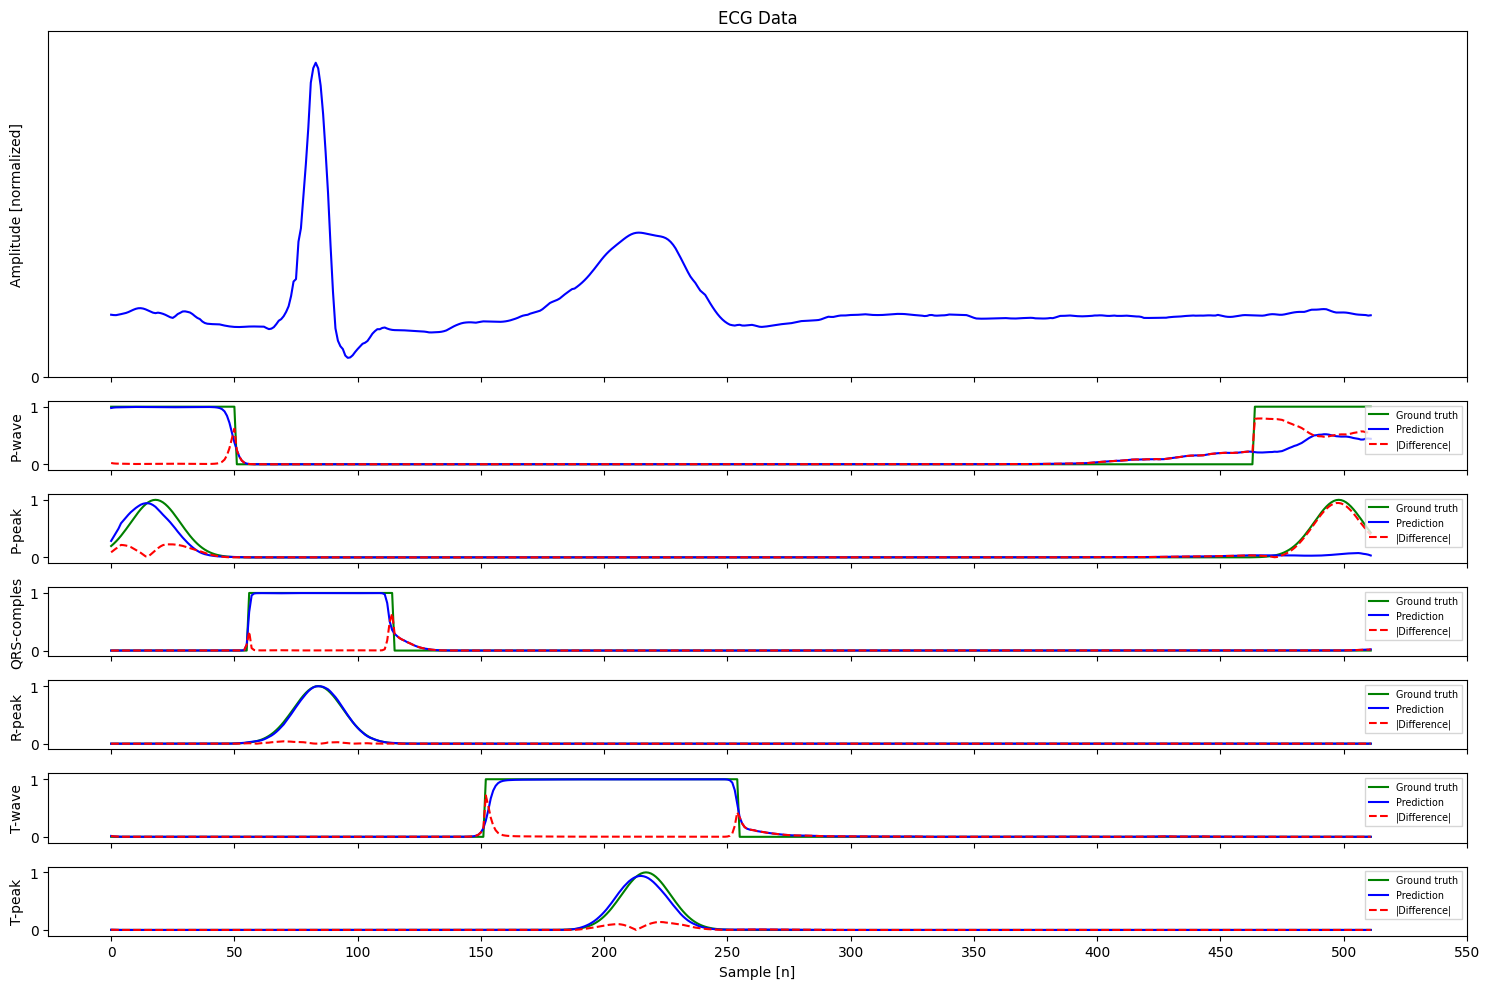

torch.Size([1, 1, 512])
torch.Size([1, 6, 512])


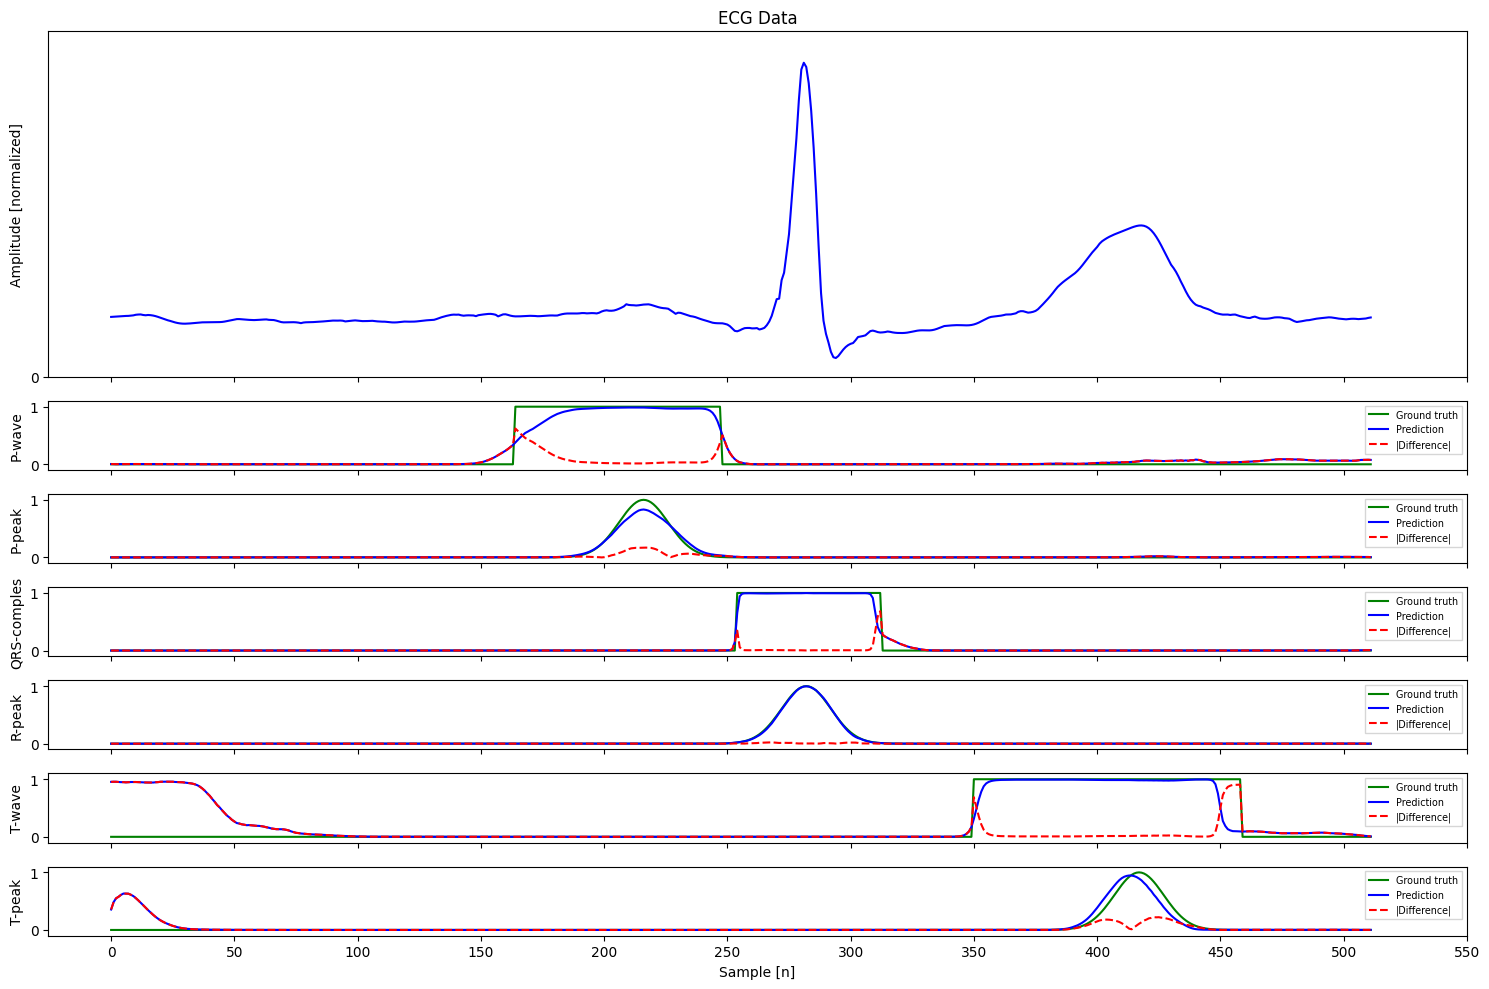

In [ ]:
# Get test dataloader for later iteration
dl = dm.test_dataloader()

# Confusing code was required to generate a plot of the ECG data and the labels...
for i in range(2):
    x_val, y_val = dl.dataset.__getitem__(i)    
    x_val.resize_(1, 1, 512)
    y_val.resize_(1, 6, 512)

    x_val = x_val.float()
    y_val = y_val.float()

    print(x_val.shape)
    print(y_val.shape)

    y_hat = model(x_val)

    y_hat = y_hat.cpu()
    x_val = x_val.cpu()
    y_val = y_val.cpu()

    x_val = x_val[0].detach()
    y_val = y_val[0].detach()
    y_hat = y_hat[0].detach()

    generatePlot(x_val, y_val, x_val, y_hat)